# Geometrical Methods in Machine Learning
## Seminar 2: ICA

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math as m
from scipy import signal
from scipy.linalg import fractional_matrix_power as matrix_power

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn import image
from nilearn.plotting import plot_stat_map, show

/Users/okachan/.virtualenvs/ml/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## 1. ICA model

Consider ICA model:

$$\mathbf{X} = \mathbf{A}\mathbf{S}$$

where $\mathbf{S} \in \mathbb{R}^{n \times d}$ - $n$ source signals of dimension $d$, $\mathbf{X} \in \mathbb{R}^{m \times d}$ - $m$ observations of dimension $d$, $\mathbf{A}$ - $m \times n$ mixing matrix, where $m \geq n, \mathrm{Rank}(\mathbf{A}) = n$.

In [2]:
np.random.seed(66)
S = np.random.logistic(0, 1, (2, 2000)) ** 3
S = S / S.std()
S[0, :] /= 4.

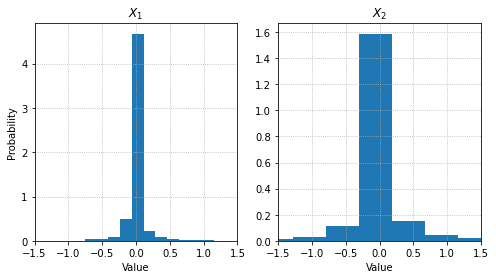

In [3]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
plt.xlim(-1.5, 1.5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_1$")
plt.hist(S[0,:], bins=50, density=True)

plt.subplot(122)
plt.xlim(-1.5, 1.5)
plt.grid(linestyle="dotted")
plt.title("$X_2$")
plt.xlabel("Value")
plt.hist(S[1,:], bins=50, density=True)

plt.show()

#### Exercise

Set mixing matrix $A = \begin{pmatrix} 1 & 1 \\ 0 & 2 \end{pmatrix}$ and define X as linear mixture 

In [4]:
# set mixing matrix A
A = np.array([[1, 1], [0, 2]])

# set X as linear mixture of S
X = A @ S

In [5]:
pca = PCA(n_components=2).fit(X.T)
ica = FastICA(n_components=2).fit(X.T)
print("PCA components:\n", pca.components_)
print("\nICA components:\n", ica.mixing_)

PCA components:
 [[ 0.45403408  0.89098432]
 [-0.89098432  0.45403408]]

ICA components:
 [[40.85271214 12.15606494]
 [81.63771302  0.15902502]]


In [6]:
ica_mixing_0 = ica.mixing_[:,0] / np.linalg.norm(ica.mixing_[:,0])
ica_mixing_1 = ica.mixing_[:,1] / np.linalg.norm(ica.mixing_[:,1])

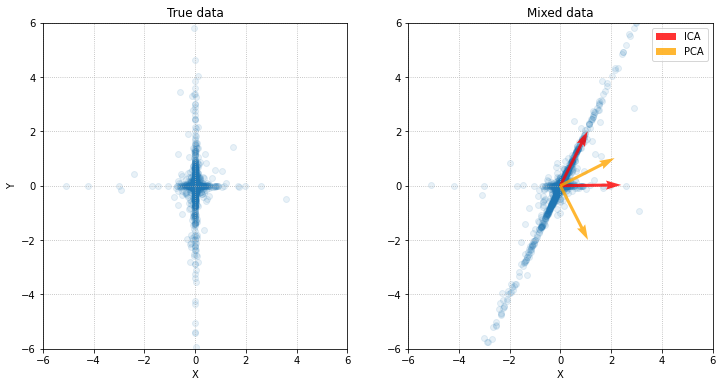

In [7]:
fig = plt.figure(figsize=(12,6))

plt.subplot(121)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("True data")
plt.scatter(S.T[:,0], S.T[:,1], alpha=0.1)

plt.subplot(122)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.xlabel("X")
plt.scatter(X.T[:,0], X.T[:,1], alpha=0.1)

plt.quiver(0, 0, ica_mixing_0[0], ica_mixing_0[1], zorder=11, width=0.01, scale=5, color='r', alpha=0.8, label='ICA')
plt.quiver(0, 0, ica_mixing_1[0], ica_mixing_1[1], zorder=11, width=0.01, scale=5, color='r', alpha=0.8)

plt.quiver(0, 0, pca.components_[0,0], pca.components_[1,0], zorder=11, width=0.01, scale=5, color='orange', alpha=0.8, label='PCA')
plt.quiver(0, 0, pca.components_[0,1], pca.components_[1,1], zorder=11, width=0.01, scale=5, color='orange', alpha=0.8)

plt.legend()
plt.show()

## 2. Data whitening

Consider a generated dataset which is sampled from multivariate normal distribution with covariance matrix $C = \begin{pmatrix} 5 & 3 \\ 3 & 2 \end{pmatrix}$

In [8]:
# sample size
sample_size = 1000

# sample from multivariate Gaussian
mu = np.random.normal(0, 0.5, 2)
C = np.array([[5, 3], [3, 2]])
data = np.random.multivariate_normal(mu, C, size=sample_size)

In [9]:
idx = (data[:,0] > 3) & (data[:,1] > 3)

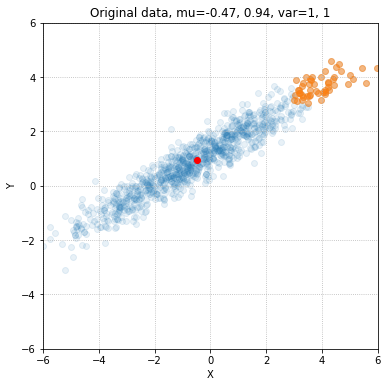

In [10]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid(linestyle="dotted")

plt.title("Original data, mu={:.2f}, {:.2f}, var=1, 1".format(mu[0], mu[1]))
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0], data[:,1], alpha=0.1)
plt.scatter(data[idx,0], data[idx,1], alpha=0.5)
plt.scatter(mu[0], mu[1], alpha=1, c='r')
plt.show()

Whitening procedure makes the samples made uncorrelated and their variances one.

Whitening has two simple steps:

1. (decorrelation) Project the dataset onto the eigenvectors (PCA). This rotates the dataset so that there is no correlation between the components.

2. (standartization) Normalize the the dataset to have a variance of 1 for all components. This is done by simply dividing each component by the square root of its eigenvalue.

Let $\mathbf{S} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^T$ is eigenvalue decomposition of sample covariance matrix $\mathbf{S} \triangleq \mathbf{X}^T\mathbf{X}$.

Then whitening matrix $\mathbf{W}$ is defined as:

$$\mathbf{W} = \mathbf{V} \mathbf{\Lambda}^{-1/2}$$

or alternatively (ZCA variant): 

$$\mathbf{W}_{ZCA} = \mathbf{V} \mathbf{\Lambda}^{-1/2} \mathbf{V}^T$$

Whitening transform is defined as:

$$\mathbf{X}' = \mathbf{W} \mathbf{X}$$

#### Exercise

Implement whitening matrix and whitening transform. Use either `scipy.linalg.fractional_matrix_power` or properties of diagonal matrix to raise it into power of $-1/2$.

In [11]:
data.shape

(1000, 2)

In [12]:
# get sample mean
x_mean = np.mean(data, axis=0)

# center data
data_centered = data - x_mean

# compute covariance matrix
covariance = data_centered.T @ data_centered / data.shape[0]
print("Covariance matrix:\n", covariance)

# obtain eigenvectors of covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance)
print("\nEigenvalues:\n", eigenvalues)
print("\nEigenvectors:\n", eigenvectors)

# compute whitening matrix
W_zca = eigenvectors @ matrix_power(np.diag(eigenvalues), -0.5) @ eigenvectors.T
print("\nZCA whitening matrix:\n", W_zca)

# compute PCA whitening matrix
W = eigenvectors @ matrix_power(np.diag(eigenvalues), -0.5)
print("\nPCA whitening matrix:\n", W)

# scale data
data_scaled = StandardScaler().fit_transform(data)

# compute whitened data
data_whitened = np.dot(data_centered, W)
data_whitened_zca = np.dot(data_centered, W_zca)

Covariance matrix:
 [[4.94194778 2.92986914]
 [2.92986914 1.9218497 ]]

Eigenvalues:
 [6.72801482 0.13578265]

Eigenvectors:
 [[ 0.85385298 -0.52051426]
 [ 0.52051426  0.85385298]]

ZCA whitening matrix:
 [[ 1.01633902 -1.03478319]
 [-1.03478319  2.08298963]]

PCA whitening matrix:
 [[ 0.32918469 -1.41257166]
 [ 0.2006731   2.3171863 ]]


#### Exercise

Check whether whitened data indeed have unit covariance.

In [13]:
np.dot(data_whitened.T, data_whitened)

array([[1.0000000e+03, 5.5067062e-14],
       [5.5067062e-14, 1.0000000e+03]])

In [14]:
np.dot(data_whitened_zca.T, data_whitened_zca)

array([[1.00000000e+03, 2.80664381e-13],
       [2.80664381e-13, 1.00000000e+03]])

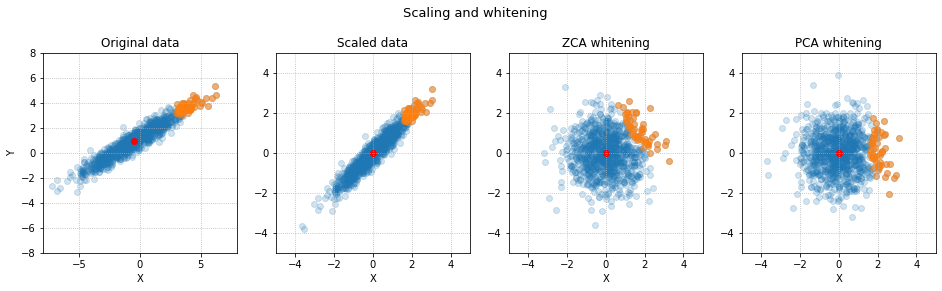

In [15]:
fig = plt.figure(figsize=(16,4))

plt.suptitle("Scaling and whitening", fontsize=13)

plt.subplot(141)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Original data")
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.scatter(data[idx,0], data[idx,1], alpha=0.5)
plt.scatter(mu[0], mu[1], alpha=1, c='r')

plt.subplot(142)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("Scaled data")
plt.xlabel("X")
plt.scatter(data_scaled[:,0], data_scaled[:,1], alpha=0.2)
plt.scatter(data_scaled[idx,0], data_scaled[idx,1], alpha=0.5)
plt.scatter(np.mean(data_scaled, axis=0)[0], np.mean(data_scaled, axis=0)[1], alpha=1, c='r')

plt.subplot(144)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("PCA whitening")
plt.xlabel("X")
plt.scatter(data_whitened[:,0], data_whitened[:,1], alpha=0.2)
plt.scatter(data_whitened[idx,0], data_whitened[idx,1], alpha=0.5)
plt.scatter(np.mean(data_whitened, axis=0)[0], np.mean(data_whitened, axis=0)[1], alpha=1, c='r')

plt.subplot(143)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("ZCA whitening")
plt.xlabel("X")
plt.scatter(data_whitened_zca[:,0], data_whitened_zca[:,1], alpha=0.2)
plt.scatter(data_whitened_zca[idx,0], data_whitened_zca[idx,1], alpha=0.5)
plt.scatter(np.mean(data_whitened_zca, axis=0)[0], np.mean(data_whitened_zca, axis=0)[1], alpha=1, c='r')

plt.subplots_adjust(top = 0.82)

plt.show()

## 3. ICA solution

### Kurtosis approach - make the output signal components most non-Gaussian

ICA algorithm is conceptually relatively simple and works as follows:

1. remove the mean and whiten (decorrelate and normalize covariance matrix to unit variance) the data
2. rotate the data such that output signal components are most non-Gaussian.

Consider a linear mixture of two sources: $X_1 \sim Laplace(0,1)$ and $X_2 \sim U(0,1)$:

In [16]:
# sample size and dimensionality
n, d = 1000, 2

X_1 = np.random.uniform(-np.sqrt(3),np.sqrt(3), (n))
X_2 = np.random.laplace(0, 0.5, (n))
X = np.vstack([X_1, X_2])
X.shape

(2, 1000)

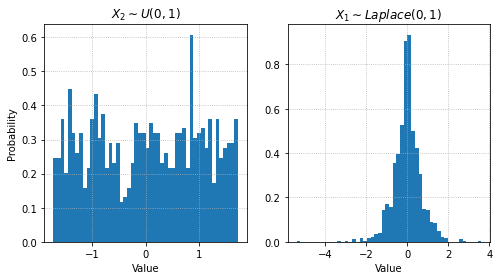

In [17]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_2 \sim U(0,1)$")
plt.hist(X_1, bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("$X_1 \sim Laplace(0,1)$")
plt.xlabel("Value")
plt.hist(X_2, bins=50, density=True)

plt.show()

#### Exercise

By defining a random mean and random mixing matrix $\mathbf{M}$ obtain mixed data.

In [18]:
# set random mean
mean = np.random.normal(0, 0.5, d)

# create random mixing matrix, 2 x 2
M = np.random.normal(0, 1, (d, d))

# mix initial sources and add mean.
Y = M @ X + mean.reshape((2, 1))

print("Initial sources:\n", X)
print("\nInitial mean:\n", mean)
print("\nMixing matrix:\n", M)
print("\nMixed data:\n", Y)

Initial sources:
 [[-0.34031393 -0.668155   -0.70088669 ...  1.0021862  -0.29175196
   1.21537873]
 [ 1.23569606 -1.14465824  0.6972165  ... -1.22567252 -0.54406784
   0.64919012]]

Initial mean:
 [0.81361914 0.51330058]

Mixing matrix:
 [[-0.34551837  0.71654583]
 [ 0.15058381 -0.66447199]]

Mixed data:
 [[ 1.81663672  0.22427888  1.55537594 ... -0.41090514  0.52457526
   0.85885793]
 [-0.35903061  1.17328059 -0.05552244 ...  1.47863865  0.8308853
   0.26494828]]


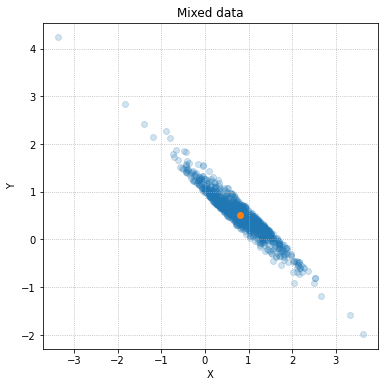

In [19]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.scatter(Y[0], Y[1], alpha=0.2)
plt.scatter(np.mean(Y.T, axis=0)[0], np.mean(Y.T, axis=0)[1], alpha=1)

plt.show()

In [20]:
def white(data):
    x_mean = np.mean(data, axis=1)
    data_centered = data - x_mean.reshape((2, 1))
    covariance = data_centered.dot(data_centered.T) / n
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    W = eigenvectors.dot(matrix_power(np.diag(eigenvalues), -0.5)).dot(eigenvectors.T)
    return np.dot(W, data_centered), data_centered, W

**Step 1:** whiten the data

In [21]:
Y_white, Y_centered, W = white(Y)
Y_white.shape, Y_centered.shape

((2, 1000), (2, 1000))

In [22]:
Y_white.dot(Y_white.T)

array([[ 1.0000000e+03, -4.1033843e-13],
       [-4.1033843e-13,  1.0000000e+03]])

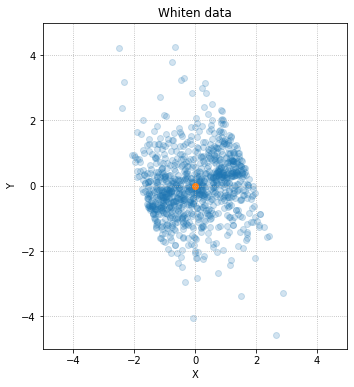

In [23]:
fig = plt.figure(figsize=(12,6))

plt.subplot(121)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Whiten data")
plt.scatter(Y_white[0], Y_white[1], alpha=0.2)
plt.scatter(np.mean(Y_white, axis=1)[0], np.mean(Y_white, axis=1)[1], alpha=1)

plt.show()

### Maximizing measure of non-Gaussianity

Loss function (_contrast_ for historical reasons) is defined as:

$$C(X) := \sum_i \mathrm{kurt}(X)^2$$

Where _kurthosis_ (corrected four-order moment or cumulant) of (multivariate) random variable $X$ is defined:

$$\mathrm{kurt}(X) = \mathbb{E}(X^4) - 3\mathbb{E}(X^2)^2$$


#### Exercise

Code the kurtosis function.

In [24]:
def kurtosis(data_centered):
    
    moment_4th_order = np.mean(data_centered ** 4, axis=1)
    moment_2th_order = np.mean(data_centered ** 2, axis=1)
    kurtosis = moment_4th_order - 3 * moment_2th_order ** 2
    
    return kurtosis

In [25]:
print(kurtosis(Y_white))

[-0.73165371  3.61355052]


#### Exercise

The contrast function is a scalar function that quantifies on the basis of fourth order cumulants how non-Gaussian the components of a signal are.

Code the loss function.

In [26]:
def loss(data_centered):
    k = kurtosis(data_centered)
    
    return np.sum(k ** 2)

In [27]:
print(loss(Y_white))

13.593064509713638


#### Exercise

**Step 2:** Find optimal rotation angle with random Givens rotations.

In higher dimensions a rotation matrix can be quite complex. To keep things simple, we use Givens rotations, which are defined as a rotation within the 2D subspace spanned by two axes n and m. For instance a  rotation matrix in 2D is given by:

$$\mathbf{R} = \begin{pmatrix} cos \phi & sin \phi \\ -sin \phi & cos \phi \end{pmatrix}$$

A rotation within the plane spanned by the second and the fourth axis ($n$ = 2, $m$ = 4) of a four-dimensional space is given by

$$\mathbf{R} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0  & cos \phi & 0 & sin \phi \\ 0 & 0 & 1 & 0 \\ 0 & -sin \phi & 0 & cos \phi \end{pmatrix}$$

It can be shown that any general rotation, i.e. any orthogonal matrix with positive determinant, can be written as a product of Givens-rotations. Thus, we can find the general rotation matrix of the ICA problem by applying a series of Givens rotations and each time improve the objective function. By applying enough of such Givens-rotations, the algorithm should eventually converge to the globally optimal solution.

This is a simple procedure to rotate the data such that the contrast function is maximized, i.e. such that the components are maximally non-Gaussian, which implies that the components are minimally statistically independent (as far as fourth order is concerned).

In [30]:
# Start with rotation angle 0, i.e. with rotation matrix [[1,0],[0,1]] and contrast of the whitened data.

bestAngle = 0
bestRotationMatrix = np.array([[1, 0], [0, 1]])
bestRotatedContrast = loss(Y_white)

losses = []

angle = 0
for iteration in np.arange(0, 10, 0.01):

    # Try a new rotation angle near the old one.
    
    # Vary the angle a bit, where 'a bit' gets exponentially smaller
    angle = angle + np.random.normal(0, m.exp(-iteration))
    
    # Calculate new rotation matrix
    rotationMatrix = np.array([[m.cos(angle), -m.sin(angle)], [m.sin(angle), m.cos(angle)]])
    
    # Calculate rotated whitened data
    rotatedData = np.dot(rotationMatrix, Y_white)
    
    # Calculate contrast ov newly rotated whitened data
    rotatedContrast = loss(rotatedData)
    
    # If contrast has improved, keep the new rotation angle, matrix, and contrast, otherwise continue with the old ones.
    if rotatedContrast > bestRotatedContrast:
        
        bestAngle = angle
        bestRotationMatrix = rotationMatrix
        bestRotatedContrast = rotatedContrast
        
        print("Loss (max): {:.4f}".format(rotatedContrast))
        
    losses.append(rotatedContrast)
        
# Display final result.
print("\nBest angle: ", bestAngle)
print("\nBest rotation matrix:\n", bestRotationMatrix)
print("\nBest rotated contrast: ", bestRotatedContrast)

Loss (max): 13.9668
Loss (max): 23.4755
Loss (max): 34.2154
Loss (max): 37.1113
Loss (max): 37.2446
Loss (max): 37.4847
Loss (max): 37.6475
Loss (max): 37.6478
Loss (max): 37.6486

Best angle:  7.376673753390241

Best rotation matrix:
 [[ 0.45938961 -0.88823487]
 [ 0.88823487  0.45938961]]

Best rotated contrast:  37.64855245935798


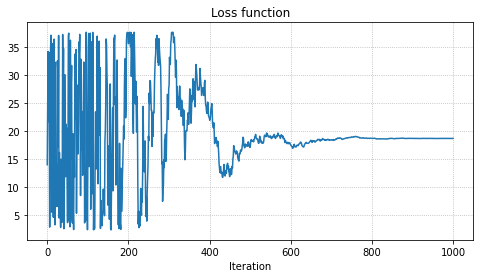

In [31]:
fig = plt.figure(figsize=(8,4))
plt.grid(linestyle="dotted")
plt.title("Loss function")
plt.xlabel("Iteration")
plt.plot(losses)

#### Exercise

Find unmixing matrix $\mathbf{U} = \mathbf{R} \mathbf{W}$ and separated sources $\mathbf{S} = \mathbf{U} \mathbf{\bar{Y}}$, where $\mathbf{\bar{Y}}$ is centered data.

In [32]:
# find unmixing matrix U
U = bestRotationMatrix @ W

# find separated sources S
S = U @ Y_centered

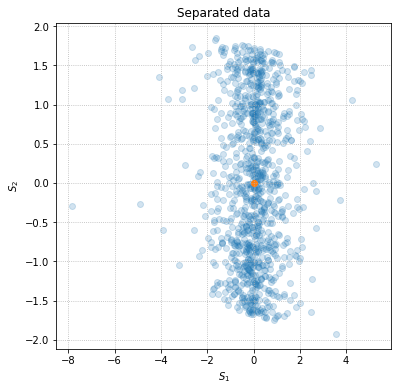

In [33]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("$S_1$")
plt.ylabel("$S_2$")
plt.grid(linestyle="dotted")
plt.title("Separated data")
plt.scatter(S[0], S[1], alpha=0.2)
plt.scatter(np.mean(S, axis=1)[0], np.mean(S, axis=1)[1], alpha=1)

plt.show()

#### Exercise

Plot the distribution of separated sources

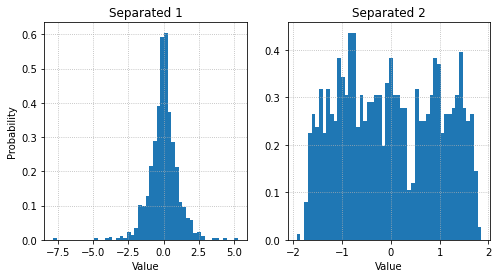

In [34]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("Separated 1")
plt.hist(S[0], bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("Separated 2")
plt.xlabel("Value")
plt.hist(S[1], bins=50, density=True)

plt.show()

## 4. Real data

### 4.1. Blind source separation

In [35]:
# set image size
shape = (512, 512)
rows, cols = shape

# load images
img1 = np.load('./data/camera.npy').flatten()
img2 = np.load('./data/astronaut.npy').flatten()
img3 = np.load('./data/moon.npy').flatten()
img4 = np.load('./data/noise.npy').flatten()

# combine images
S = np.c_[img1, img2, img3, img4].T

In [36]:
# set random mixing matrix A
A = np.random.uniform(0.01, 0.9, (4, 4))

# mix data
X = np.dot(A, S)
X.shape

(4, 262144)

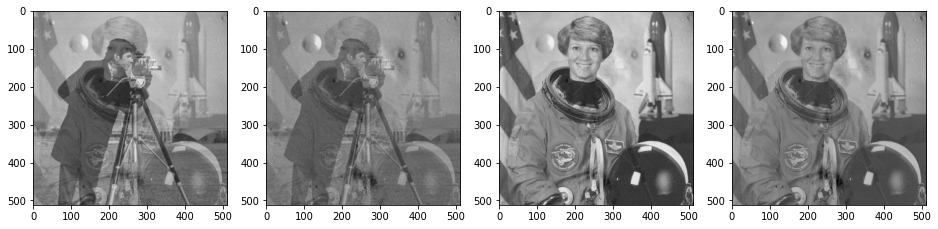

In [37]:
# show images
f, ax = plt.subplots(1, X.shape[0])
f.set_size_inches((16,4))

for i in range(X.shape[0]):
    ax[i].imshow(X[i,:].reshape(rows, cols), cmap=plt.gray())

#### Exercise

Run ICA with different number of `n_components`. Compare results, conclude.

In [38]:
# run ICA
ica = FastICA(n_components=4)
img_ica = ica.fit_transform(X.T)
img_ica.shape

(262144, 4)

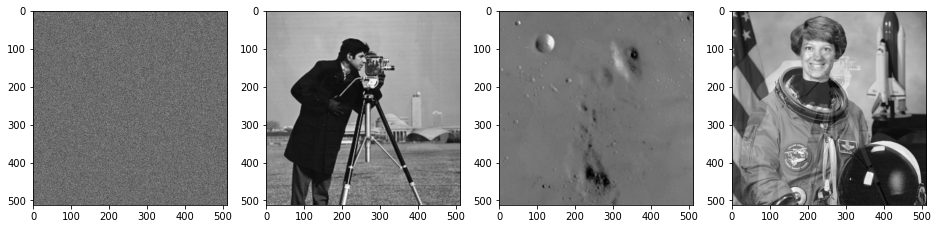

In [39]:
# show images
f, ax = plt.subplots(1, img_ica.shape[1])
f.set_size_inches((16,4))

for i in range(img_ica.shape[1]):
    ax[i].imshow(img_ica[:,i].reshape(shape), cmap=plt.gray())

### 4.2. Time series

In [40]:
np.random.seed(42)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3.5 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(1.5 * np.pi * time) # sawtooteh

S = np.c_[s1, s2, s3]
#S += np.array([0, 0, np.random.normal()])  # Add noise

S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
#A = np.random.normal(0, 1, (3, 3))
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
#assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

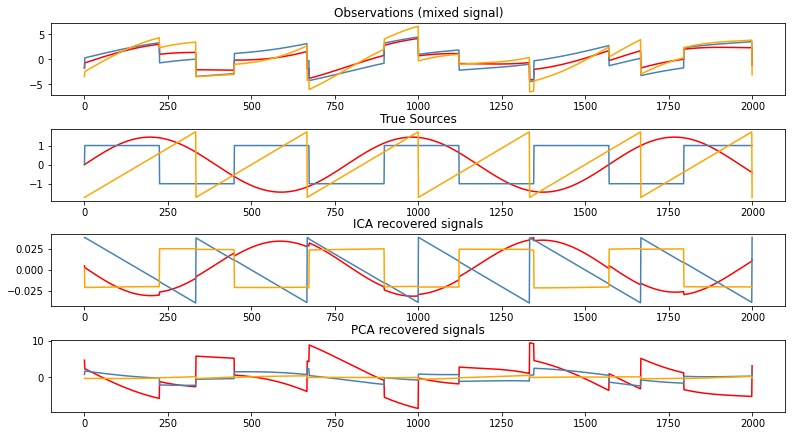

In [41]:
fig = plt.figure(figsize=(12,6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

## 5. fMRI data

The fMRI signal is represented by a $t \times v$ data matrix $\mathbf{X}$, where $t$ is the number of time points and $v$ is the number of voxels in the volumes. This means that each row of $\mathbf{S}$ contains an independent spatial pattern and the corresponding column of $\mathbf{A} \in \mathbb{R}^{t \times t}$ holds its activation time-course.

In [42]:
256 ** 3 * 150

2516582400

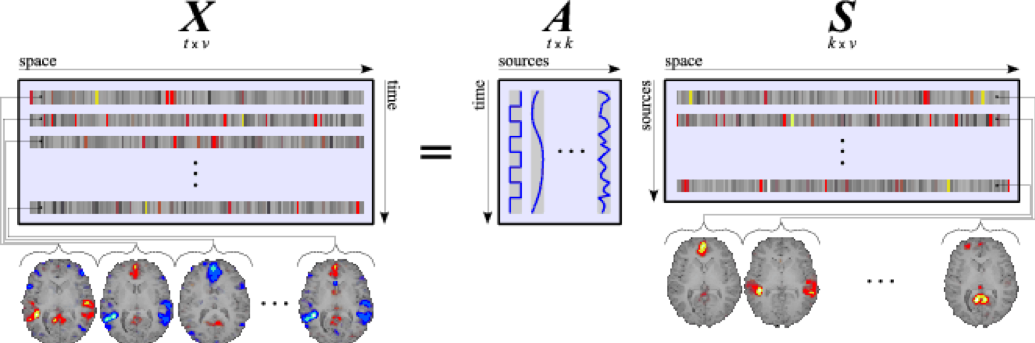

In [43]:
from IPython.display import Image
Image("img/fmri.png")

In [44]:
# fetch patient data
dataset = datasets.fetch_adhd(n_subjects=1)
func_filename = dataset.func[0]

# extract time series
masker = NiftiMasker(smoothing_fwhm=8, memory='nilearn_cache', detrend=True, standardize=True)
fmri_data = masker.fit_transform(func_filename)

fmri_data.shape


Dataset created in /Users/okachan/nilearn_data/adhd



 ...done. (1 seconds, 0 min)
Extracting data from /Users/okachan/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz..... done.
/Users/okachan/.virtualenvs/ml/lib/python3.10/site-packages/nilearn/datasets/func.py:250: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  phenotypic = np.genfromtxt(phenotypic, names=True, delimiter=',',


Downloaded 43220992 of 44414948 bytes (97.3%,    0.8s remaining) ...done. (29 seconds, 0 min)
Extracting data from /Users/okachan/nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz..... done.


(176, 69681)

#### Exercise

Plot every 1000-th voxel activation time course.

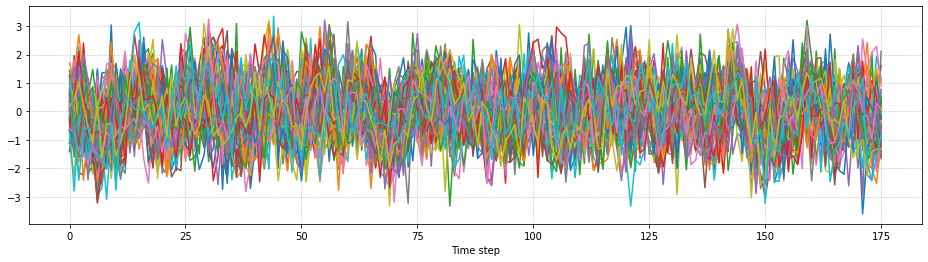

In [45]:
fig = plt.figure(figsize=(16,4))
plt.grid(linestyle="dotted")
plt.xlabel("Time step")

for i in range(0, fmri_data.shape[1], 1000):
    plt.plot(fmri_data[:,i])

#### Exercise

Fit ICA to fMRI data to extract desired number of independent components.

In [46]:
n_components = 50

# apply ICA on spatial domain
ica = FastICA(n_components=n_components, random_state=42)
components = ica.fit_transform(fmri_data.T).T

/Users/okachan/.virtualenvs/ml/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/okachan/.virtualenvs/ml/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


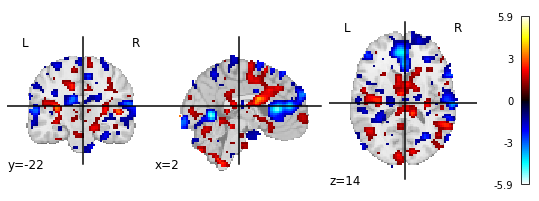

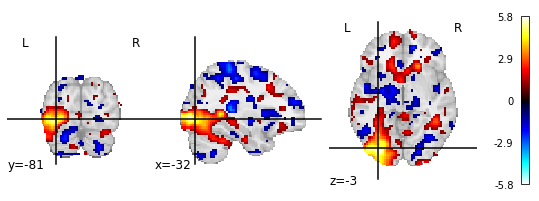

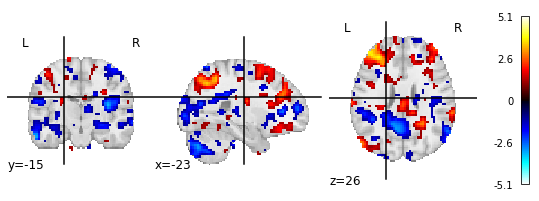

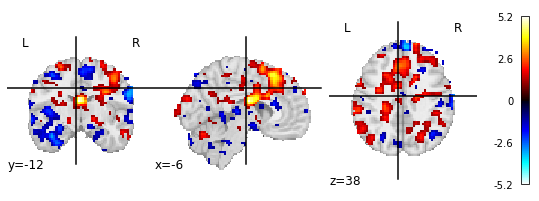

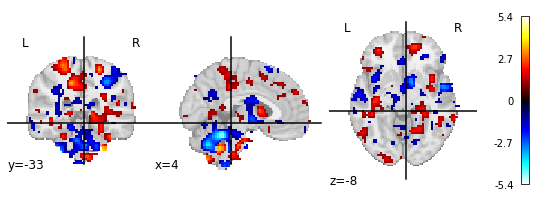

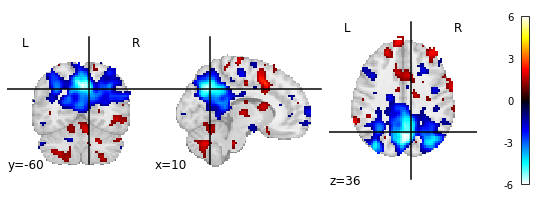

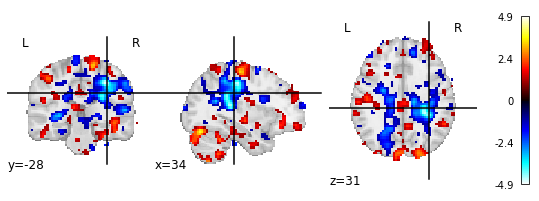

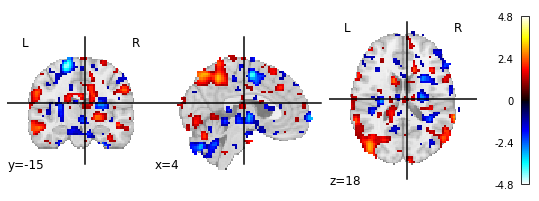

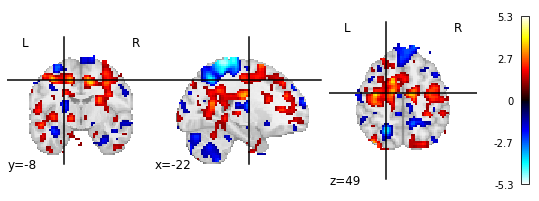

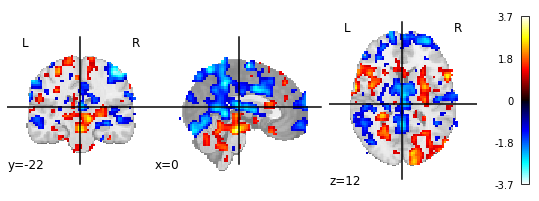

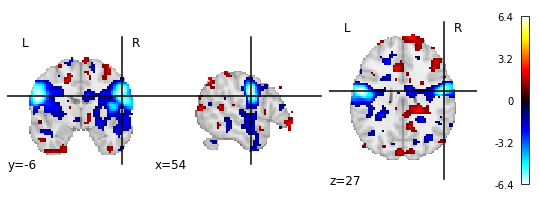

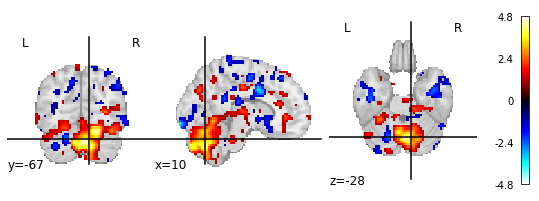

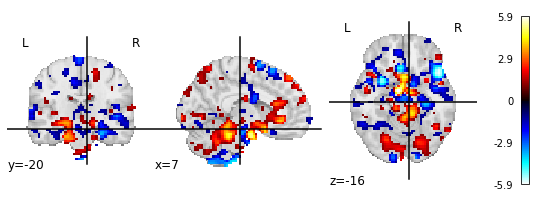

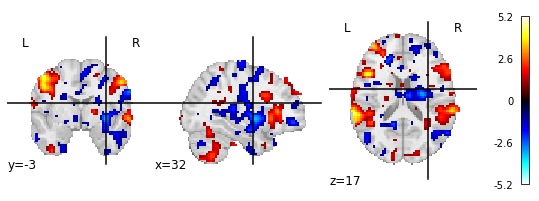

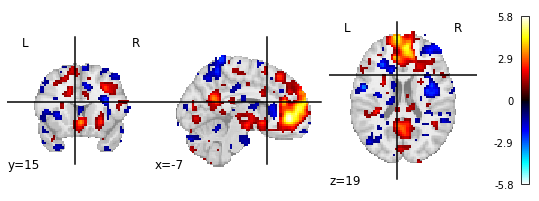

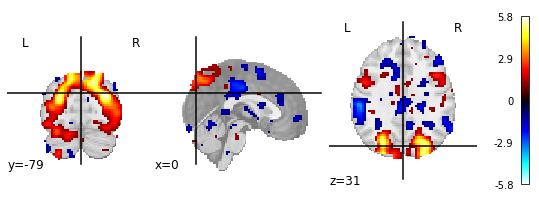

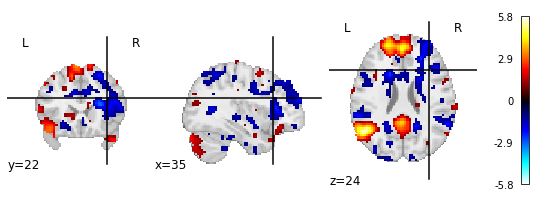

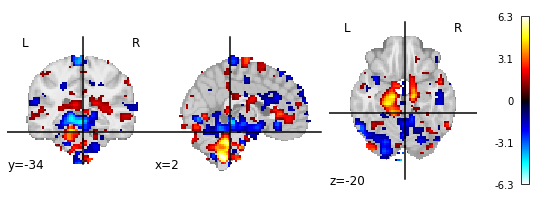

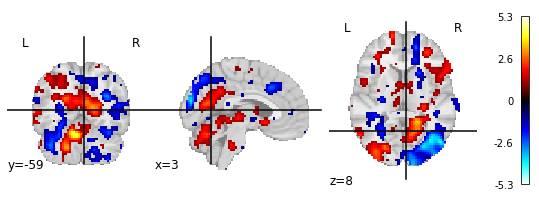

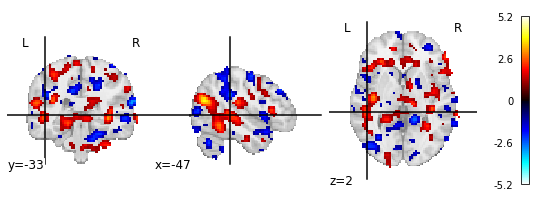

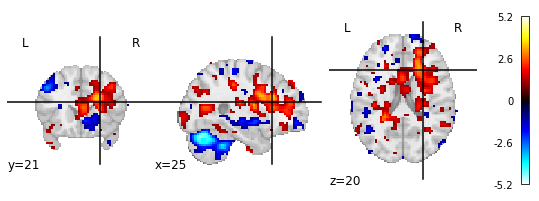

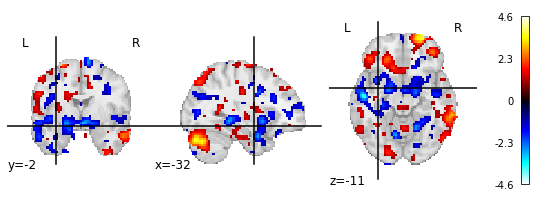

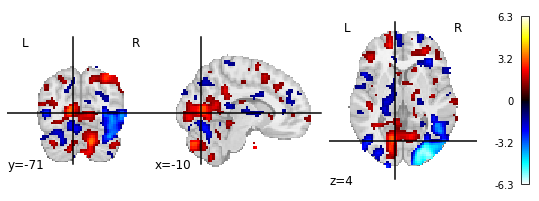

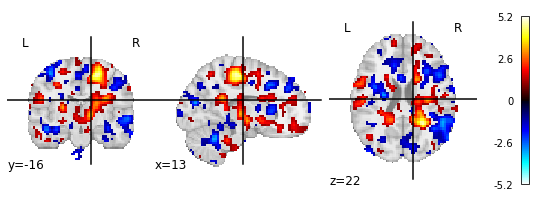

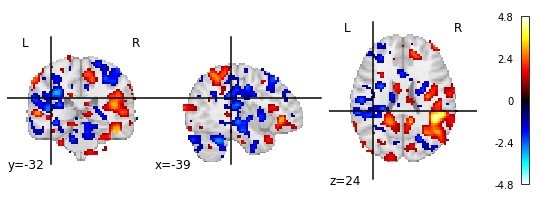

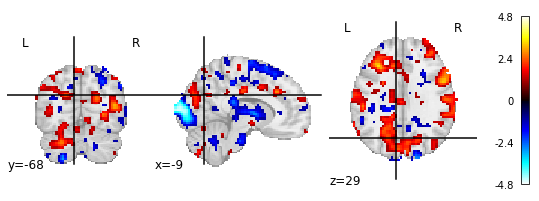

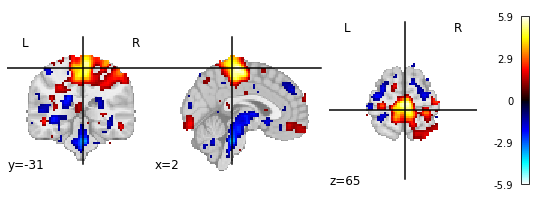

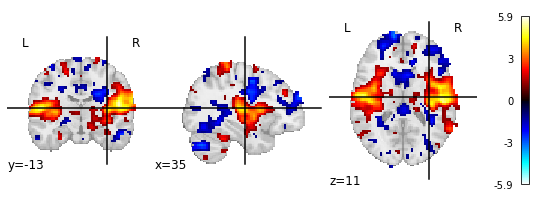

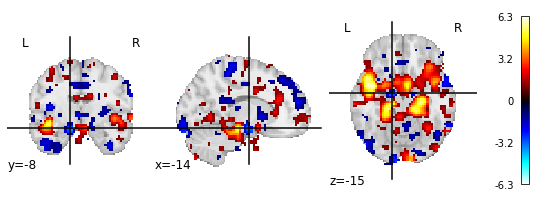

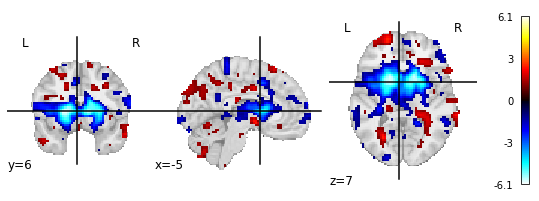

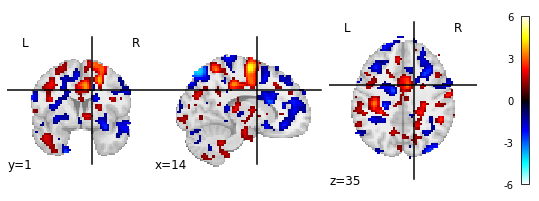

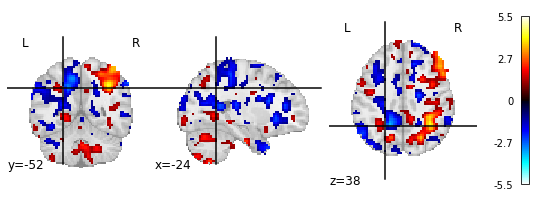

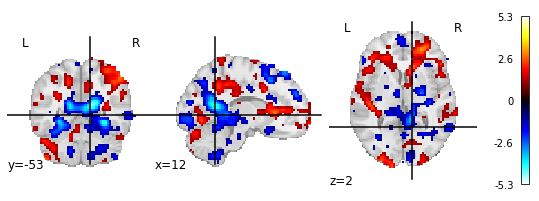

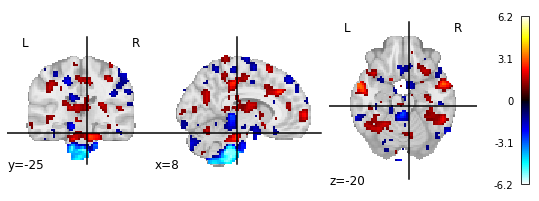

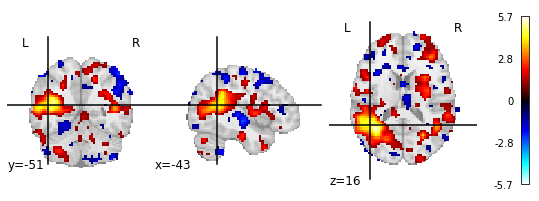

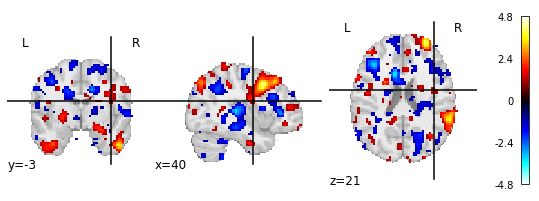

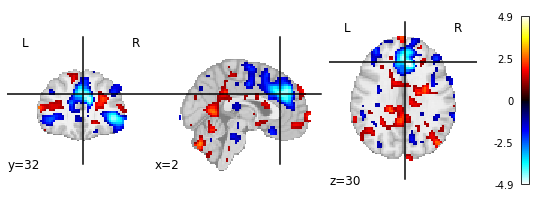

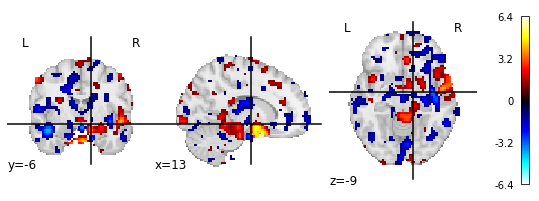

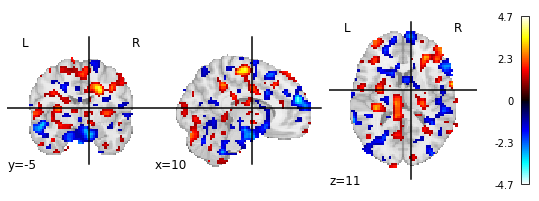

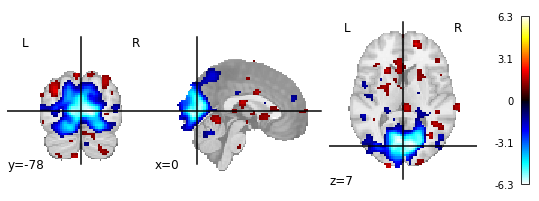

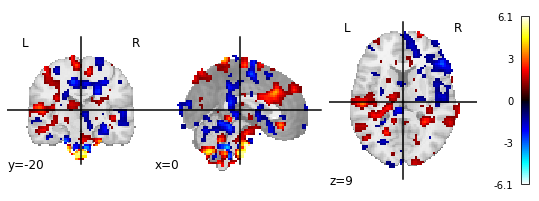

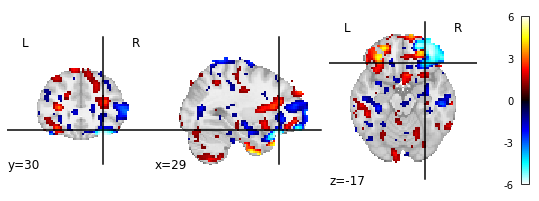

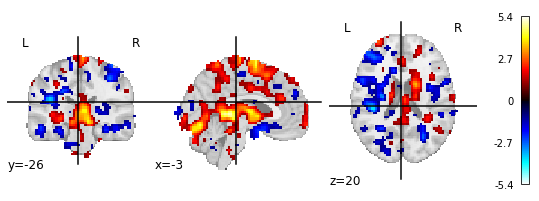

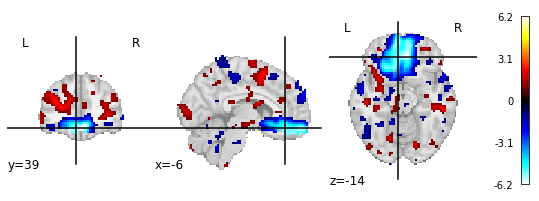

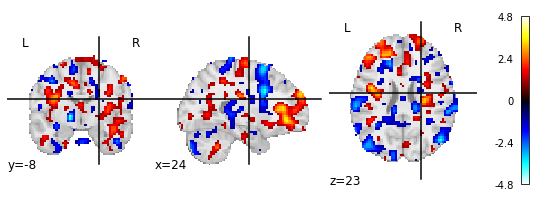

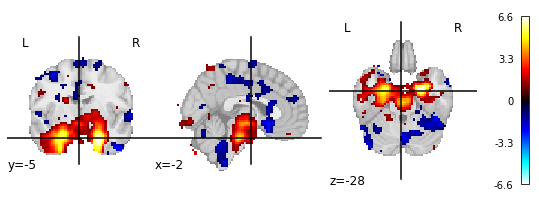

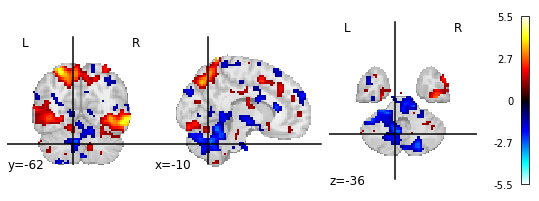

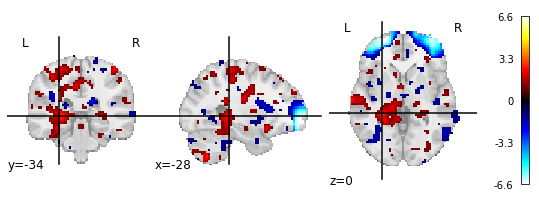

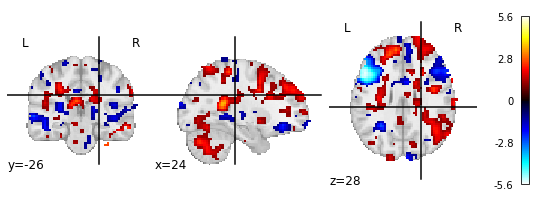

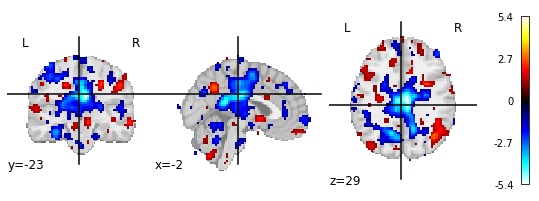

In [47]:
# normalize estimated components, for thresholding to make sense
components -= components.mean(axis=0)
components /= components.std(axis=0)

# threshold
components[np.abs(components) < 1.0] = 0

# now invert the masking operation, projecting to original space
component_img = masker.inverse_transform(components)

# plot image
mean_img = image.mean_img(func_filename)

for i in range(n_components):
    plot_stat_map(image.index_img(component_img, i))